# Titanic: Machine Learning from Disaster 
## Predict survival on the Titanic using simple Logistic Regression

### Overview:
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.



### Data:
The data has been split into two groups:

training set (train.csv)
test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

#### Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
<br>
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.



In [131]:
# imporing the standard libarary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# imporing packages for machine learning
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# set up display area to show dataframe in jupyter qtconsole
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [132]:

## Wonderful solution to show labels in bar plots - copied from https://stackoverflow.com/a/48372659 and edited
def showLabels(ax, d=None):
    plt.margins(0.2, 0.2)
    rects = ax.patches
    i = 0
    locs, labels = plt.xticks() 
    counts = {}
    if not d is None:
        for key, value in d.items():
            counts[str(key)] = value

    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = 5
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        if d is None:
            label = "{:.1f}".format(y_value)
        else:
            try:
                label = "{:.1f}%".format(y_value) + "\nof " + str(counts[str(labels[i].get_text())])
            except:
                label = "{:.1f}%".format(y_value)
        
        i = i+1

        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

In [133]:
#def plot_percentages(dataframe, var_list, sortbyindex=False):
## Plot the percentage of passangers onboard on Titanic with respect to different list of features
#    plt.figure(figsize=(20, 17))
#    for var in var_list:
#        plt.subplot(3,4,var_list.index(var)+1)
#        values = (dataframe[var].value_counts(normalize=True)*100)
#        if sortbyindex:
#                values = values.sort_index()
#        ax = values.plot.bar(color=sns.color_palette('deep', 16))
#        ax.set_ylabel('% in dataset', fontsize=16)
#        ax.set_xlabel(var, fontsize=10)
#        showLabels(ax)

In [134]:
# This method prints two plots side by side 
# Left one is percentage of a categorical variable in the entire dataset 
# Right one is percentage for Charged Off loans 
def plot_percentages(dataframe, by, sortbyindex=False):
    #plt.subplot(1, 2, 1)
    values = (dataframe[by].value_counts(normalize=True)*100)
    if sortbyindex:
        values = values.sort_index()
    ax = values.plot.bar(color=sns.color_palette('deep',16))
    ax.set_ylabel('Total % in dataset', fontsize=16)
    ax.set_xlabel(by, fontsize=12)
    showLabels(ax)
    #plt.subplot(1, 2, 2)
    grp = dataframe.groupby(['Survived',by])[by].count()
    cnt = dataframe.groupby(by)[by].count()
    #print(grp)
    percentages = grp.unstack() * 100 / cnt.T
    #print(percentages)
    ax = percentages.plot.bar(color=sns.color_palette('deep', 16))
    ax.set_ylabel('% Survived', fontsize=16)
    showLabels(ax)

In [135]:
# read the test data
testdf = pd.read_csv('test.csv')
# making the copy of the orignal test data
test = testdf[:] 
print('test set shape :{} '.format(test.shape))
# read the train data
train = pd.read_csv('train.csv')
print('train set shape :{} '.format(train.shape))
print('train set info :{} '.format(train.info()))
train.head()

test set shape :(418, 11) 
train set shape :(891, 12) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
train set info :None 


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [136]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Handeling Missing Values

From above we observe missing values for some features<br>
Let's check.

In [137]:
# Checking the null percentage of missing data
missing_per = round(train.isnull().sum()/len(train)*100,2)
missing_per[missing_per != 0]

Age         19.87
Cabin       77.10
Embarked     0.22
dtype: float64

Out of the 891 train records, 20% of the data has no Age for the passangers and 77% of data with missing cabin information. Also 2 records dont have the Embarked port name. <br>Let's handel these missing data.

In [138]:
missing_count=train.isnull().sum()
missing_count[missing_count >0.0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [139]:
# Handling the missing Embarked port
train[train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Since, both these persons dont have any siblings / spouses/ parents or children. We cannot infer there Port of Embarkment.Now we can,
1. impute the missing value with the mode of Embarked port.
2. remove these two records from analysis and modeling

Going with the first option, imput the missing port of embarkment with the mode i.e S: 644

In [140]:
train['Embarked'].fillna('S',inplace=True)
train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

#### Handling the missing Age

In [141]:
train[train.Age.isnull()].Survived.value_counts()

0    125
1     52
Name: Survived, dtype: int64

In [142]:
# Average age of passangers
print('Average Age of passangers : {}'.format(train.Age.mean()))
# Mean age of passangers who survived vs the one who did not survived
train.groupby('Survived').Age.mean()

Average Age of passangers : 29.69911764705882


Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

Out of the 177 missing Age values there are 125 records who did not survive.<br> Overall the average age of passangers is 29.69 while the average among those who survived(1) is 28.3 and average age among non-survivors is 30.62.<br>
1. One way is that we replace the null Age's with the mean of the passangers. However Age can be potential predictor of  survival and hense imputing the 20% of data with mean value we may add significance bais to the model.
2. Another approach to impute can be to create a regression model to predict the missing age of passangers
3. Ignore these 177 records. This will lower the train data size but will avoid adding bias

We will impute the missing values with random integers lying between 1 standard deviation away from mean.

In [143]:
# creating a custom function
def imputeAge(df,column) :
    '''This function will impute the missing values with random integer value
    lying within 1 standard deviation of the mean'''
    dataset = df[:]
    mean = df[column].mean()
    std = df[column].std()
    is_null = dataset[column].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset[column].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset[column] = age_slice
    dataset[column] = df[column].astype(int)
#train["Age"].isnull().sum()

In [144]:
imputeAge(train,'Age')
train["Age"].isnull().sum()

0

In [145]:
train.Age.describe()

count    891.000000
mean      29.654512
std       13.566562
min        0.420000
25%       21.000000
50%       28.500000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

#### Handling the missing Cabin
There are 70% records with missing Cabin value. Since the percentage missing data is very high, it will be best if we ignore this feature by dropping the entire column from analysis.

In [146]:
train.drop('Cabin',axis=1,inplace=True)
# Check missing value
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

There are no more missing values in the train set. We can start Analysing the data in depth.

##### Checking for Outliers

In [147]:
# Checking for outliers in the continuous variables
num_train = train[['Age','Fare']]
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
num_train.describe(percentiles=[.25, .5, .75, .90, .95, .99])

,Age,Fare
count,891.000000,891.000000
mean,29.654512,32.204208
std,13.566562,49.693429
min,0.420000,0.000000
25%,21.000000,7.910400
50%,28.500000,14.454200
75%,38.000000,31.000000
90%,47.000000,77.958300
95%,54.000000,112.079150
99%,65.000000,249.006220


-  Age of the passangers are gradually increasing suggesting no outliers in Age.
-  We see that the Fare jumps dramatically after 99 pecentile from 211.33 to 247.52. This suggest there are some outliers towards the end of the Fare distribution. Let's remove these outliers as the model is sensitive to outliers.

In [148]:
#fareMean=train.Fare.mean()
#fareSd=train.Fare.std()
#train = train[np.abs(train['Fare']-fareMean) <= (3*fareSd)]
q = train["Fare"].quantile(0.99)
train = train[train['Fare'] < q]

In [149]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
train['Fare'].describe(percentiles=[.25, .5, .75, .90, .95, .99])

count    882.000000
mean      29.002508
std       36.569302
min        0.000000
25%        7.895800
50%       14.454200
75%       30.500000
90%       73.500000
95%       93.500000
99%      211.337500
max      247.520800
Name: Fare, dtype: float64

### Data Correction and Exploratory Data Analysis

### Univariate Analysis

#### Feature: PassengerId

In [150]:
train.PassengerId.head()

0    1
1    2
2    3
3    4
4    5
Name: PassengerId, dtype: int64

This column clearly is a sequential Id assigned to the passenger. This wont be of any significance in predicting the survival. We will later remove this column from analysis.

#### Feature: Survived
This is the dependent variable which needs to be predicted.

In [151]:
print(train.Survived.value_counts())
### Checking the Survival Rate
survival_rate = round((sum(train[train['Survived']==1]['Survived'])/len(train['Survived'].index))*100,2)
print('Survival Rate : {}'.format(survival_rate))

0    547
1    335
Name: Survived, dtype: int64
Survival Rate : 37.98


- In this training data we have 549 passangers who survived and 342 passangers who din't survive.
- The training data ha a **Survival Rate of 38.38%**

#### Feature: Pclass
This feature tells us about the Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd of onboard passengers.

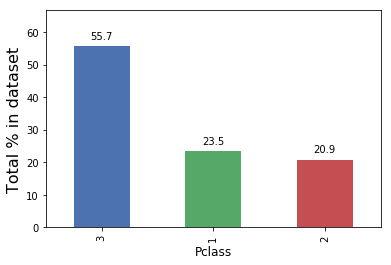

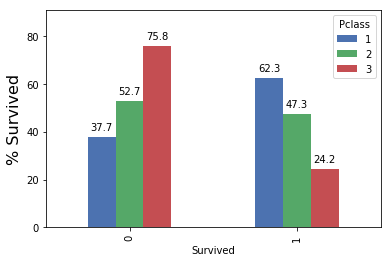

In [152]:
#showLabels(sns.countplot(train.Pclass))
plot_percentages(train,'Pclass')
plt.show()

Pclass is int type but the values represent are ordinal categorical type categorising the passenger into 1st,2nd and 3rd class. 55% of the passangers are traveling 3rd class. While 24% travel First class and 21% 2nd class.

#### Feature: Name
This column has the names of all the passangers onboard.

In [153]:
print('Number of unique Passangers: {} '.format(len(train.Name.unique())))
train.Name.head()

Number of unique Passangers: 882 


0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Considering Name as primary Key. We see that there are no duplicate records in the data set and all passangers have a unique name.<br>
We will use the Name feature to extract the Titles from the Name, so that we can build a new feature out of that.

In [154]:
# Extracting the title from the name
train.Name.str.extract(' ([A-Za-z]+)\.', expand=False).value_counts()

Mr          513
Miss        177
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Sir           1
Capt          1
Countess      1
Don           1
Mme           1
Lady          1
Jonkheer      1
Ms            1
Name: Name, dtype: int64

In [155]:
def extract_createTitle(df,column):
    '''This function returns the list of titles from the passangers Name'''
    dataset = df
    #titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    # extract titles
    dataset['Title'] = dataset[column].str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    return dataset['Title']
    # convert titles into numbers
    #dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    #dataset['Title'] = dataset['Title'].fillna(0)

In [156]:
train['Title'] = extract_createTitle(train,'Name')

In [157]:
train.Title.value_counts()

Mr        513
Miss      180
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64

#### Feature: Sex
This column information about the sex of the passanger, Male or Female

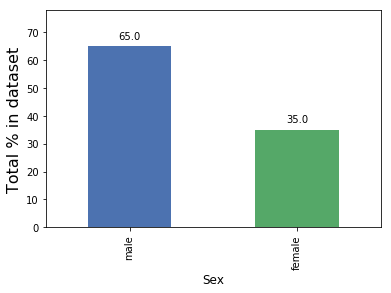

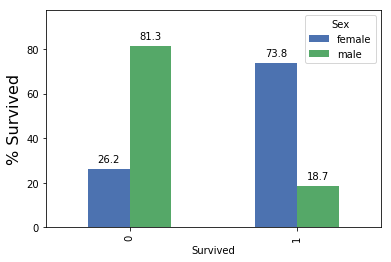

In [158]:
plot_percentages(train,'Sex')

-  There were Male passangers(65%) onboard than Female(35%).
-  The percentage female survivers were way beyond the male survivers. 74.2% of the survivers were female.
-  This confirms that females and child were asked to evacuated first.
-  Men had a low probability of surviving.

#### Feature: Age
This column information about the Age of the passanger.

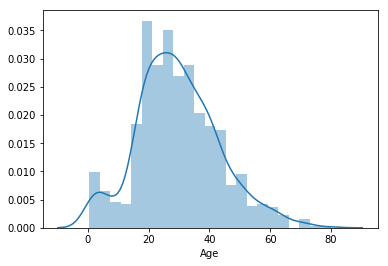

Mean Age : 29.645317460317457


In [159]:
sns.distplot(train.Age)
plt.show()
print('Mean Age : {}'.format(train.Age.mean()))

In [160]:
train.groupby('Survived').Age.mean()

Survived
0    30.234918
1    28.682597
Name: Age, dtype: float64

- Overall the average age of passangers onboard was 29.5
-  Mean age of passanger who survived was 28.3
-  Mean age of passangers who did not survive was 30.26

In [161]:
bins = [0,10,20,30,40,50,60,70,np.inf]
labels = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70+']
age_groups = pd.cut(train.Age, bins, labels=labels)
train['age_group'] = age_groups

In [162]:
#bins = [0, 12, 17, 60, np.inf]
#labels = ['child', 'teenager', 'adult', 'elder']
#age_groups = pd.cut(train.Age, bins, labels=labels)
#train['age_group'] = age_groups

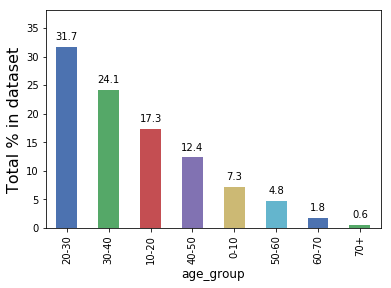

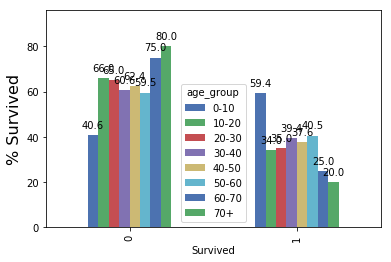

In [163]:
# Droping the orignal Age Column
#train.drop('AgeBin',axis=1,inplace=True)
plot_percentages(train,'age_group')

-  Majority passangers on board, 33.8% fall in the age group of 20-30
-  59.5% of the children below the age of 10 years managed to survive. This further confirms that childern were evecuated first.

#### Feature: SibSp
The dataset defines family relations in this way... Sibling = brother, sister, stepbrother, stepsister Spouse = husband, wife (mistresses and fiancés were ignored)

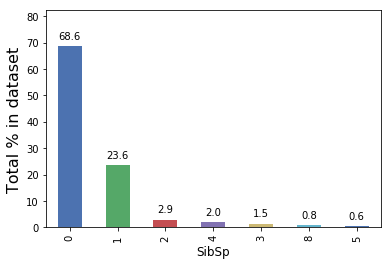

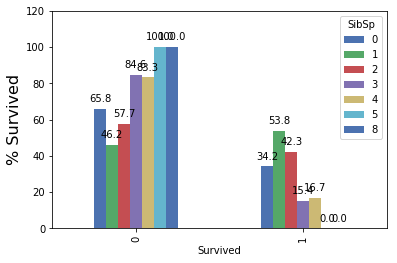

In [164]:
plot_percentages(train,'SibSp')

-  68% passangers did not have any Siblings or Spouse
-  Passangers having 1 Sibling or 1 spouse had greated chances of survival. 53.6% of such passangers survived.

#### Feature: Parch
The dataset defines family relations in this way... Parent = mother, father Child = daughter, son, stepdaughter, stepson Some children travelled only with a nanny, therefore parch=0 for them.

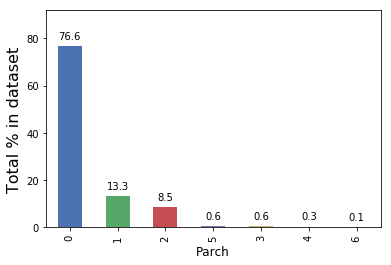

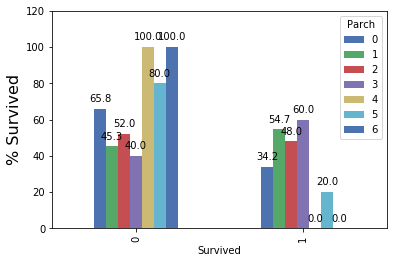

In [165]:
plot_percentages(train,'Parch')

-  76.1% of the passangers did not have any parents/child onboard
- If passangers survival rate is high when the number of parents/child onboard = 1

In [166]:
train.loc[(train['Parch'] == 0)  & (train['SibSp'] == 0)]['Survived'].value_counts(normalize=True)

0    0.699065
1    0.300935
Name: Survived, dtype: float64

-  Passangers survival perventage is very small if the passanger was travelling alone i.e without any Sibling, Spouce, Parent or Child.

#### Feature: Ticket
Ticket number

In [167]:
train.Ticket.head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [168]:
# How many unique Ticket are there 
print('There are {} Unique Tickets values for the passangers'.format(len(train.Ticket.unique())))

There are 678 Unique Tickets values for the passangers


#### Feature: Fare
Passenger fare

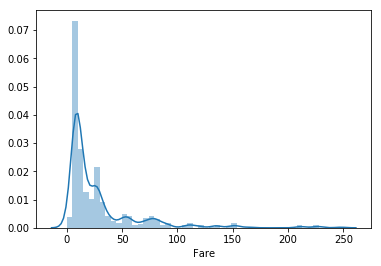

count    882.000000
mean      29.002508
std       36.569302
min        0.000000
25%        7.895800
50%       14.454200
75%       30.500000
max      247.520800
Name: Fare, dtype: float64

In [169]:
sns.distplot(train.Fare)
plt.show()
train.Fare.describe()

Fare is a continuos variable. Let's cut the Fare into discreate fare ranges or Bins for easier interpretation.

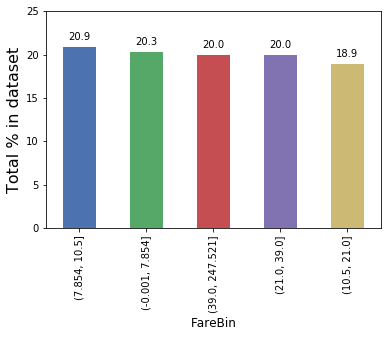

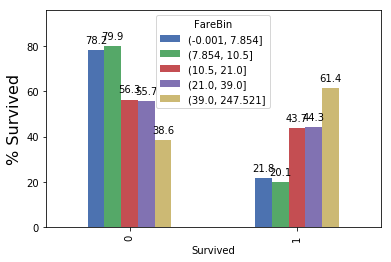

In [170]:
# Creating a new column to store the Fare range for each passanger
train['FareBin']=pd.qcut(train.Fare,q=5)
plot_percentages(train,'FareBin')

-  It can be obeserved that the Fare has some positive correlation with the survival of the passanger.
-  The chances of survival of a passanger are improving as the fare is increasing.

#### Feature: Cabin
Passenger Cabin number. This column was dropped earlier from the analysis as 77 of the Canin entries were empty/Null.

#### Feature: Embarked
Passenger port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

In [171]:
train.Embarked.value_counts()

S    642
C    163
Q     77
Name: Embarked, dtype: int64

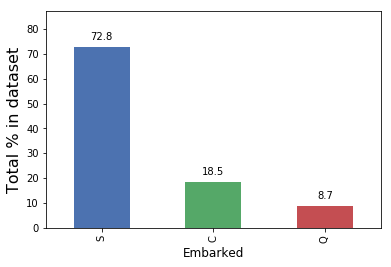

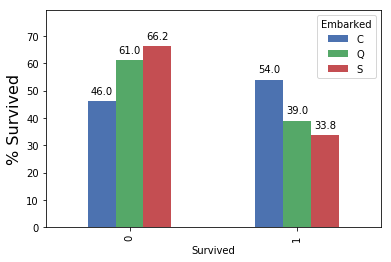

In [172]:
plot_percentages(train,'Embarked')

-  Most of the passangers, around 72.5% embarked from S=Southampton port.
- Survived %
    - 55.4% passangers survived who embarked from Cherbourg
    - 39% passangers survived who embarked from Queenstown
    - 33.9% passangers survived who embarked from Southhampton port

### Bivariate Analysis

###### Pclass and Sex

In [173]:
train.groupby(['Pclass','Sex']).Survived.value_counts(normalize=False)

Pclass  Sex     Survived
1       female  1            86
                0             3
        male    0            75
                1            43
2       female  1            70
                0             6
        male    0            91
                1            17
3       female  0            72
                1            72
        male    0           300
                1            47
Name: Survived, dtype: int64

- We already saw that the % of females survivers were way too high 74%.
- Among the survived most of them travelled either 1st Class or 2nd Class.

###### Age and Sex

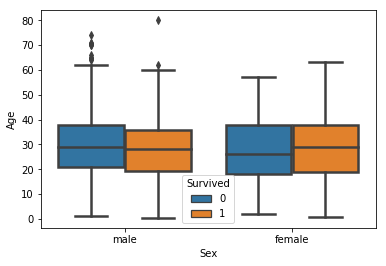

In [174]:
ax = sns.boxplot(x="Sex", y="Age", hue="Survived",data=train, linewidth=2.5)

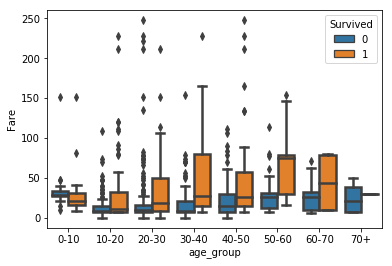

In [175]:
ax = sns.boxplot(x="age_group", y="Fare", hue="Survived",data=train, linewidth=2.5)

In [176]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,age_group,FareBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,20-30,"(-0.001, 7.854]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,30-40,"(39.0, 247.521]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,20-30,"(7.854, 10.5]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,30-40,"(39.0, 247.521]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,30-40,"(7.854, 10.5]"


##### Removing variables irrelevent for predicting Survival

In [177]:
nonPredicter=['PassengerId','Name','Ticket']
train.drop(nonPredicter,axis=1,inplace=True)

##### Handeling Categorical Variables

In [178]:
# Encoding Sex values male and female to binary 0 and 1.
sexdic={'male': 0 , 'female': 1}
train['Sex'] = train['Sex'].map(sexdic)

For categorical variables with multiple levels, create dummy features (one-hot encoded)¶

In [179]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'age_group', 'FareBin'], dtype='object')

In [180]:
dummy = pd.get_dummies(train[['Embarked','Title','age_group','FareBin']], drop_first=True)
# Adding the results to the master dataframe
train = pd.concat([train, dummy], axis=1)

In [181]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,age_group,FareBin,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,age_group_10-20,age_group_20-30,age_group_30-40,age_group_40-50,age_group_50-60,age_group_60-70,age_group_70+,"FareBin_(7.854, 10.5]","FareBin_(10.5, 21.0]","FareBin_(21.0, 39.0]","FareBin_(39.0, 247.521]"
0,0,3,0,22.0,1,0,7.2500,S,Mr,20-30,"(-0.001, 7.854]",0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,1,1,38.0,1,0,71.2833,C,Mrs,30-40,"(39.0, 247.521]",0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
2,1,3,1,26.0,0,0,7.9250,S,Miss,20-30,"(7.854, 10.5]",0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,1,1,1,35.0,1,0,53.1000,S,Mrs,30-40,"(39.0, 247.521]",0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
4,0,3,0,35.0,0,0,8.0500,S,Mr,30-40,"(7.854, 10.5]",0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0


In [182]:
# We have created dummies for the below variables, so we can drop them
train = train.drop(['Embarked','Title','age_group','FareBin'], 1)

### Feature Scaling

In [183]:
X_train = train.drop('Survived',axis=1)
y_train = train['Survived']

In [184]:
scaler = StandardScaler()
X_train[['Age','Fare']] = scaler.fit_transform(X_train[['Age','Fare']])
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,age_group_10-20,age_group_20-30,age_group_30-40,age_group_40-50,age_group_50-60,age_group_60-70,age_group_70+,"FareBin_(7.854, 10.5]","FareBin_(10.5, 21.0]","FareBin_(21.0, 39.0]","FareBin_(39.0, 247.521]"
0,3,0,-0.563898,1,0,-0.595167,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,1,0.616219,1,0,1.156839,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
2,3,1,-0.268869,0,0,-0.576699,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,1,1,0.394947,1,0,0.659328,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
4,3,0,0.394947,0,0,-0.573279,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0


#### Looking at Correlations

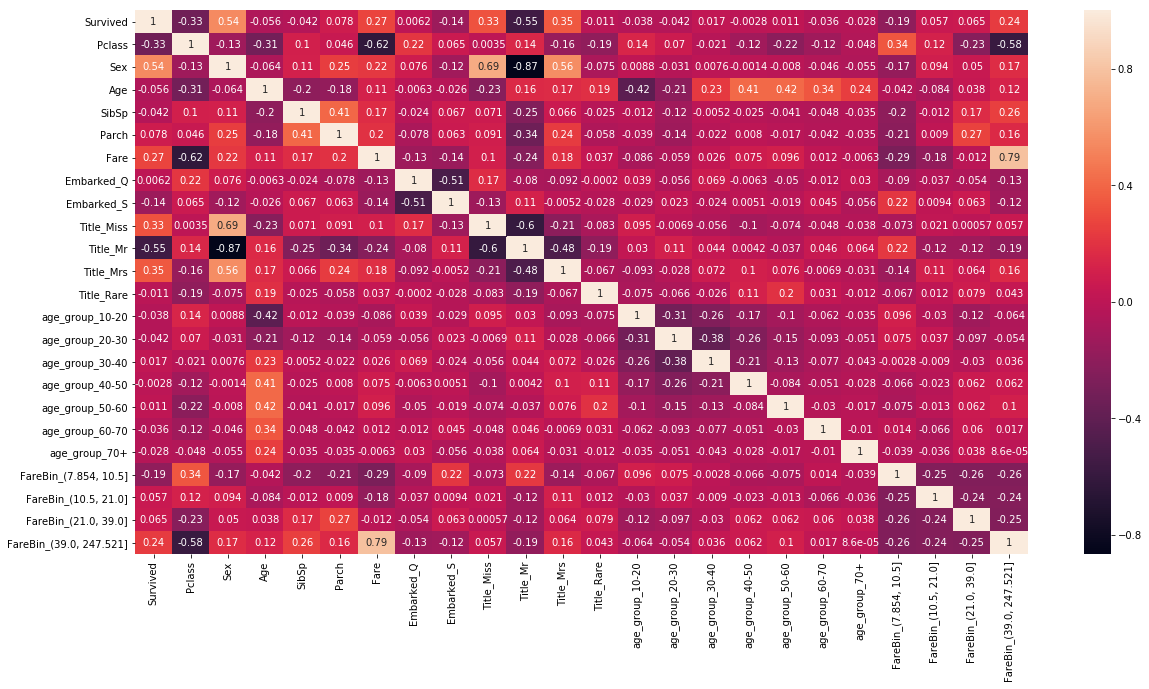

In [185]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(train.corr(),annot = True)
plt.show()

-  The correlation matrix above shows how each of the variable is related to the other.
-  This only shows the a probable relation and does not imply causation.
-  The feature Sex is highly co-related to Title_Miss and Title_Mrs. Let's remove the Title_* from analysis as the Sex of the passanger is a more interpretable predictor of survival.

In [186]:
X_train = X_train.drop(['Title_Mrs','Title_Miss','Title_Mr','Title_Rare'],axis=1)

### Model Building

We will use a mix approach for building the model. A mix of Automated and manual feature selection techniques to reach the final model.<br>Selecting appropriate features for prediction is a key step. Its becomes very important that we consider predictors that strongly contribute to prediction of the independent variable, in this case the passanger's Survival.

Lets use RFE module available in the sklearn library to course tune the model by selecting top 10 features among the various featurs that most contribute or are determinant in predicting Survival.<br>
After RFE we will manually look at the feature significance using the statistic metrics of p-value, VIF, correlation etc and further tune the final model predictor variables.

#### Feature Selection Using RFE

In [187]:
# running the logstic regression from sklearn and using RFE for selecting 10 initial features for the model
logreg = LogisticRegression()
rfe= RFE(logreg,10)
rfe = rfe.fit(X_train,y_train)

In [188]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Pclass', True, 1),
 ('Sex', True, 1),
 ('Age', True, 1),
 ('SibSp', True, 1),
 ('Parch', False, 3),
 ('Fare', False, 7),
 ('Embarked_Q', False, 10),
 ('Embarked_S', True, 1),
 ('age_group_10-20', True, 1),
 ('age_group_20-30', True, 1),
 ('age_group_30-40', False, 4),
 ('age_group_40-50', False, 8),
 ('age_group_50-60', False, 6),
 ('age_group_60-70', False, 5),
 ('age_group_70+', True, 1),
 ('FareBin_(7.854, 10.5]', False, 9),
 ('FareBin_(10.5, 21.0]', True, 1),
 ('FareBin_(21.0, 39.0]', False, 2),
 ('FareBin_(39.0, 247.521]', True, 1)]

In [189]:
# RFE selected features
col = X_train.columns[rfe.support_]

In [190]:
# Features rejected by the initial RFE
X_train.columns[~rfe.support_]

Index(['Parch', 'Fare', 'Embarked_Q', 'age_group_30-40', 'age_group_40-50', 'age_group_50-60', 'age_group_60-70', 'FareBin_(7.854, 10.5]', 'FareBin_(21.0, 39.0]'], dtype='object')

##### Assessing the model with StatsModels

In [191]:
# linear regression from sklearn used above does not give model statistic 
# Using the Statmodel GLM to train the model to give the model stats
X_train_sm = sm.add_constant(X_train[col])
logm1 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  882
Model:                            GLM   Df Residuals:                      871
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -384.07
Date:                Thu, 20 Dec 2018   Deviance:                       768.14
Time:                        23:49:16   Pearson chi2:                     948.
No. Iterations:                     5                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.6096      0.408      3.943      0.000       0.810       2.410
Pclass                     -1.0329      0.142     -7.281      0.000      -1.311      -0.755
Sex                         2.7124      0.198     13.670      0.000       2.324       3.101
Age                        -0.7194      0.127     -5.677      0.000      -0.968      -0.471
SibSp                      -0.4655      0.121     -3.833      0.000      -0.704      -0.227
Embarked_S                 -0.4107      0.204     -2.014      0.044      -0.810      -0.011
age_group_10-20            -1.1363      0.320     -3.555      0.000      -1.763      -0.510
age_group_20-30            -0.7425      0.232     -3.203      0.001      -1.197      -0.288
age_group_70+               0.9111      1.253      0.727      0.467      -1.545       3.367
FareBin_(10.5, 21.0]        0.2798      0.229      1.224      0.221      -0.168       0.728
FareBin_(39.0, 247.521]     0.3281      0.298      1.100      0.271      -0.256       0.912
===========================================================================================
"""

-  feature age_group_70+ is having a high P-value(>0.05), hense we will drop this feature as it is not significant in predicting Survival of passanger on Titanic.

In [192]:
col = col.drop('age_group_70+')

In [193]:
# Training the model again after removing the non significant feature
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  882
Model:                            GLM   Df Residuals:                      872
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -384.30
Date:                Thu, 20 Dec 2018   Deviance:                       768.61
Time:                        23:49:16   Pearson chi2:                     947.
No. Iterations:                     5                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.6182      0.408      3.967      0.000       0.819       2.418
Pclass                     -1.0333      0.142     -7.283      0.000      -1.311      -0.755
Sex                         2.7043      0.198     13.668      0.000       2.317       3.092
Age                        -0.7018      0.124     -5.663      0.000      -0.945      -0.459
SibSp                      -0.4606      0.121     -3.808      0.000      -0.698      -0.224
Embarked_S                 -0.4200      0.203     -2.065      0.039      -0.819      -0.021
age_group_10-20            -1.1187      0.318     -3.518      0.000      -1.742      -0.495
age_group_20-30            -0.7349      0.231     -3.180      0.001      -1.188      -0.282
FareBin_(10.5, 21.0]        0.2786      0.228      1.221      0.222      -0.169       0.726
FareBin_(39.0, 247.521]     0.3220      0.298      1.079      0.281      -0.263       0.907
===========================================================================================
"""

-  P-value for Feature:FareBin_(39.0, 247.521] is > 0.05, hense making the feature insignificant for prediction. Let's remove it and rebuild the model agin.

In [194]:
col = col.drop('FareBin_(39.0, 247.521]')

In [195]:
# Training the model again after removing the non significant feature
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  882
Model:                            GLM   Df Residuals:                      873
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -384.88
Date:                Thu, 20 Dec 2018   Deviance:                       769.77
Time:                        23:49:16   Pearson chi2:                     949.
No. Iterations:                     5                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8657      0.337      5.533      0.000       1.205       2.527
Pclass                  -1.1153      0.120     -9.282      0.000      -1.351      -0.880
Sex                      2.7123      0.197     13.749      0.000       2.326       3.099
Age                     -0.6948      0.123     -5.642      0.000      -0.936      -0.453
SibSp                   -0.4263      0.117     -3.640      0.000      -0.656      -0.197
Embarked_S              -0.4526      0.201     -2.255      0.024      -0.846      -0.059
age_group_10-20         -1.1060      0.318     -3.479      0.001      -1.729      -0.483
age_group_20-30         -0.7181      0.231     -3.114      0.002      -1.170      -0.266
FareBin_(10.5, 21.0]     0.2331      0.225      1.038      0.299      -0.207       0.673
========================================================================================
"""

-  P-value for Feature:FareBin_(10.5, 21.0] is > 0.05, hense making the feature insignificant for prediction. Let's remove it and rebuild the model agin.

In [196]:
col = col.drop('FareBin_(10.5, 21.0]')

In [197]:
# Training the model again after removing the non significant feature
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  882
Model:                            GLM   Df Residuals:                      874
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -385.42
Date:                Thu, 20 Dec 2018   Deviance:                       770.84
Time:                        23:49:16   Pearson chi2:                     944.
No. Iterations:                     5                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.8782      0.337      5.570      0.000       1.217       2.539
Pclass             -1.0997      0.119     -9.251      0.000      -1.333      -0.867
Sex                 2.7304      0.197     13.886      0.000       2.345       3.116
Age                -0.7053      0.123     -5.732      0.000      -0.946      -0.464
SibSp              -0.4331      0.117     -3.716      0.000      -0.661      -0.205
Embarked_S         -0.4453      0.200     -2.223      0.026      -0.838      -0.053
age_group_10-20    -1.1336      0.317     -3.579      0.000      -1.754      -0.513
age_group_20-30    -0.7242      0.230     -3.142      0.002      -1.176      -0.272
===================================================================================
"""

P-values of all the variable is now < 0.05 and therefore are significant in pridicting Survival of passanger

###### Let's check the VIF

VIF will tell how well each of the indepenent variable is explained by all the other independent variabels together.<br> VIF suggest how an independent variable is explained by other independent variables. In short it points us to any multicolinearity among the variables.

In [198]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,Pclass,4.25
4,Embarked_S,3.13
6,age_group_20-30,1.86
5,age_group_10-20,1.77
1,Sex,1.42
2,Age,1.40
3,SibSp,1.37


All variables have a good value of VIF. So we need not drop any more variables and we can proceed with making predictions using this model.

In [199]:
# predicting the survival probability on the train set
y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred[0:10]

array([0.06749958, 0.93346952, 0.58167489, 0.91309035, 0.10482223,
       0.15507712, 0.28215206, 0.15094302, 0.56896544, 0.83975979])

Creating a dataframe with the actual Survival flag and the predicted probabilities

In [200]:
y_train_pred_final = pd.DataFrame({'Survived':y_train.values, 'Survival_Prob':y_train_pred})
y_train_pred_final['PassengerID'] = y_train.index
y_train_pred_final.head()

,Survival_Prob,Survived,PassengerID
0,0.067500,0,0
1,0.933470,1,1
2,0.581675,1,2
3,0.913090,1,3
4,0.104822,0,4


Now lets just classify the passangers based on the computed Survival_prob. Initially categorising passangers with probability greater than 0.5 as Survivors and less than 0.5 as non-Survivors

In [201]:
# Creating a new field 'Predicted' with 1 is Survival_Prob > 0.5
y_train_pred_final['predicted'] = y_train_pred_final.Survival_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Survival_Prob,Survived,PassengerID,predicted
0,0.067500,0,0,0
1,0.933470,1,1,1
2,0.581675,1,2,1
3,0.913090,1,3,1
4,0.104822,0,4,0


In [202]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Survived, y_train_pred_final.predicted )
print(confusion)

[[474  73]
 [ 92 243]]


In [203]:
# Predicted     not_Survived    Survived
# Actual
# not_Survived        476      71
# Survived            92       243  

From the confustion matrix after classifying at 0.5 probability cutoff tells how many survived and non-survived were correctly predicted by the model

In [204]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Survived, y_train_pred_final.predicted))

0.8129251700680272


### Metrics beyond simply accuracy

**Sensitivity:** Describes how accuratetly the model is able to predict the survivors correctly.<br>
**Spesificity:** Describes how the accurately the model is able to predict the non-Survivors correctly.<br>
**False Positive Rate:** Out of the non-survivors how many the model falsely classified as survivors.

In [205]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [206]:
# Let's see the sensitivity of our logistic regression model
print('Sensitivity: {}'.format(TP / float(TP+FN)))
# Let us calculate specificity
print('Specificity: {}'.format(TN / float(TN+FP)))
# Calculate false postive rate - predicting churn when customer does not have churned
print('False Positive Rate: {}'.format(FP/ float(TN+FP)))
# positive predictive value 
print('Positive predictive value: {}'.format(TP / float(TP+FP)))
# Negative predictive value
print('Negative Predictive value: {}'.format(TN / float(TN+ FN)))

Sensitivity: 0.7253731343283583
Specificity: 0.8665447897623401
False Positive Rate: 0.13345521023765997
Positive predictive value: 0.7689873417721519
Negative Predictive value: 0.8374558303886925


##### Plotting the ROC Curve

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [207]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [208]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Survived, y_train_pred_final.Survival_Prob, drop_intermediate = False )

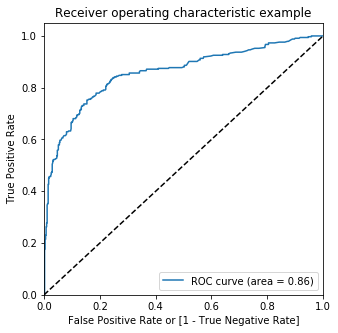

In [209]:
draw_roc(y_train_pred_final.Survived, y_train_pred_final.Survival_Prob)

What is the ROC curve saying?
-  The curve is suggesting that the models TPR is becoming almost stable after 0.8. This is not bad at all.
-  It can further be pushed to reach a ideal TPR of 1 by making some changes to the model.
-  This can be done by adding more predictive features to the model to make more accurate predictions. Creating additional meaningful features using the exiting features.

### Finding Optimal Cutoff Point


Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [210]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Survival_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Survival_Prob,Survived,PassengerID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.067500,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0.933470,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0.581675,1,2,1,1,1,1,1,1,1,0,0,0,0
3,0.913090,1,3,1,1,1,1,1,1,1,1,1,1,1
4,0.104822,0,4,0,1,1,0,0,0,0,0,0,0,0


In [211]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Survived, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.379819  1.000000  0.000000
0.1   0.1  0.575964  0.925373  0.361974
0.2   0.2  0.726757  0.865672  0.641682
0.3   0.3  0.784580  0.835821  0.753199
0.4   0.4  0.794785  0.779104  0.804388
0.5   0.5  0.812925  0.725373  0.866545
0.6   0.6  0.807256  0.623881  0.919561
0.7   0.7  0.795918  0.516418  0.967093
0.8   0.8  0.758503  0.388060  0.985375
0.9   0.9  0.701814  0.223881  0.994516


/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


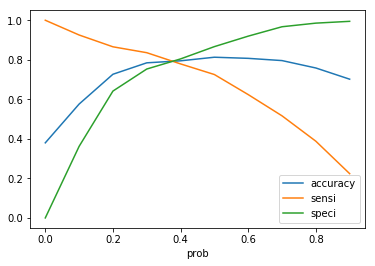

In [212]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

-  From the obove curve we can choose the optimal point to take it as the cutoff probability.
-  It can be observed that somewhere between 0.3 and 0.4 we have a point where all the three parameters are finding a balance.
- Choosing a optimal point comes with a trade off in metrics. In the case of Titanic surviaval prediction we will prioritize Sensitity as we dont want the model classify a survivor as non-survivor.
- This trade off can increase the cases were a non-survivor is classified as Survivor.
-  From the curve above, **0.35 is the optimum point to be considered as a cutoff probability.**

In [242]:
# Using 0.35 as the cutoff probabilty lets find the final_predicted Survival status of the passanger.
y_train_pred_final['final_predicted'] = y_train_pred_final.Survival_Prob.map( lambda x: 1 if x > 0.35 else 0)
y_train_pred_final.head()

,Survival_Prob,Survived,PassengerID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0.067500,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0.933470,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0.581675,1,2,1,1,1,1,1,1,1,0,0,0,0,1
3,0.913090,1,3,1,1,1,1,1,1,1,1,1,1,1,1
4,0.104822,0,4,0,1,1,0,0,0,0,0,0,0,0,0


In [214]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Survived, y_train_pred_final.final_predicted)

0.7845804988662132

In [215]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Survived, y_train_pred_final.final_predicted )
confusion2

array([[412, 135],
       [ 55, 280]])

In [216]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [217]:
# Let's see the sensitivity of our logistic regression model
print('Sensitivity: {}'.format(TP / float(TP+FN)))
# Let us calculate specificity
print('Specificity: {}'.format(TN / float(TN+FP)))
# Calculate false postive rate - predicting churn when customer does not have churned
print('False Positive Rate: {}'.format(FP/ float(TN+FP)))
# positive predictive value 
print('Positive predictive value: {}'.format(TP / float(TP+FP)))
# Negative predictive value
print('Negative Predictive value: {}'.format(TN / float(TN+ FN)))

Sensitivity: 0.835820895522388
Specificity: 0.753199268738574
False Positive Rate: 0.24680073126142596
Positive predictive value: 0.6746987951807228
Negative Predictive value: 0.8822269807280514


##### Precision
- Out of the predicted survivors how many where predicted correctly<br>
TP / TP + FP

In [218]:
confusion = metrics.confusion_matrix(y_train_pred_final.Survived, y_train_pred_final.final_predicted )
confusion

array([[412, 135],
       [ 55, 280]])

In [219]:
precision_score(y_train_pred_final.Survived,y_train_pred_final.final_predicted)

0.6746987951807228

##### Recall
- Out of the actual survivors how many were predicted as survivors<br>
TP / TP + FN

In [220]:
recall_score(y_train_pred_final.Survived,y_train_pred_final.final_predicted)

0.835820895522388

### Making predictions on the test set

##### Preparing test data for applying the model

In [221]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [222]:
#Checking for any missing data in test set
missing_count=test.isnull().sum()
missing_count[missing_count >0.0]

Age       86
Fare       1
Cabin    327
dtype: int64

- Feature:Age, Fare and Cabin are having missing values

In [223]:
# Impute the missing Age with the imputeAge function defined for the train set
imputeAge(test,'Age')
test["Age"].isnull().sum()

0

In [224]:
test[test.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


-  Missing Fare can be either imputed or this record can be removed.
-  To impute we can use a linear regression model on the train data to get the missing Fare value in the test data. This is another task by itself which can be taken up.
- We will choose to simply impute with the mean fare of the train set.
- Cabin column can simply be removed as it was also removed from the train set on account of having large missing values.

In [225]:
test.loc[test.Fare.isnull(),['Fare']] = train.Fare.mean()

In [226]:
test.drop('Cabin',axis=1,inplace=True)

In [227]:
# creating age_group feature from the Age feature
bins = [0,10,20,30,40,50,60,70,np.inf]
labels = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70+']
age_groups = pd.cut(test.Age, bins, labels=labels)
test['age_group'] = age_groups

In [228]:
# Creating a new column to store the Fare range for each passanger
test['FareBin']=pd.qcut(test.Fare,q=5)

In [229]:
# Dropping the features not required for predicting survival
test.drop(nonPredicter,axis=1,inplace=True)

In [230]:
# Encoding Sex values male and female to binary 0 and 1.
test['Sex'] = test['Sex'].map(sexdic)

In [231]:
dummy = pd.get_dummies(test[['Embarked','age_group','FareBin']], drop_first=True)
# Adding the results to the master dataframe
test = pd.concat([test, dummy], axis=1)
# We have created dummies for the below variables, so we can drop them
test = test.drop(['Embarked','age_group','FareBin'], 1)

In [232]:
# Applying the scaling from the train set to the test set
X_test = test
X_test[['Age','Fare']] = scaler.transform(X_test[['Age','Fare']])
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,age_group_10-20,age_group_20-30,age_group_30-40,age_group_40-50,age_group_50-60,age_group_60-70,age_group_70+,"FareBin_(7.796, 11.342]","FareBin_(11.342, 21.679]","FareBin_(21.679, 46.34]","FareBin_(46.34, 512.329]"
0,3,0,0.358068,0,0,-0.579320,1,0,0,0,1,0,0,0,0,1,0,0,0
1,3,1,1.280034,1,0,-0.602007,0,1,0,0,0,1,0,0,0,0,0,0,0
2,2,0,2.386393,0,0,-0.528475,1,0,0,0,0,0,0,1,0,1,0,0,0
3,3,0,-0.195111,0,0,-0.556520,0,1,0,1,0,0,0,0,0,1,0,0,0
4,3,1,-0.563898,1,1,-0.457337,0,1,0,1,0,0,0,0,0,0,1,0,0


In [233]:
# Selecting only the predictor features
X_test = X_test[col]
X_test.head()

,Pclass,Sex,Age,SibSp,Embarked_S,age_group_10-20,age_group_20-30
0,3,0,0.358068,0,0,0,0
1,3,1,1.280034,1,1,0,0
2,2,0,2.386393,0,0,0,0
3,3,0,-0.195111,0,1,0,1
4,3,1,-0.563898,1,1,0,1


Making predictions on the test set

In [234]:
# Adding constant and applying the trained model for prediction of Suvival probability
X_test_sm = sm.add_constant(X_test)
y_test_pred = res.predict(X_test_sm)

In [235]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
# Let's see the head
y_pred_1.head()

,0
0,0.157972
1,0.384228
2,0.118751
3,0.079234
4,0.526146


In [256]:
# Creating new dataframe with 'Survival_prob' and 'Survived' columns
y_test_df = pd.DataFrame(testdf[['PassengerId']])
# Appending y_test_df and y_pred_1
y_test_df = pd.concat([y_test_df, y_pred_1],axis=1)

In [257]:
# Renaming the column 
y_test_df= y_test_df.rename(columns={ 0 : 'Survived'})
y_test_df.head()

,PassengerId,Survived
0,892,0.157972
1,893,0.384228
2,894,0.118751
3,895,0.079234
4,896,0.526146


In [262]:
y_test_df['Survived'] = y_test_df.Survived.map(lambda x: 1 if x > 0.35 else 0)
y_test_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [263]:
# Calculating the Survived percentage in the test set
print('Surival rate in the test data set: {}%'.format(round(y_test_df.Survived.sum()/len(y_test_df) *100,2)))

Surival rate in the test data set: 44.26%


Writing the final submission file in the desired format with two columns 'PassangerId' and 'Survived'

In [264]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
y_test_df.to_csv('Titanic_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [265]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("Titanic_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
